# **HUD Project — Baseline para Detección de Objetos**

Este cuaderno desarrolla un **experimento inicial de detección de objetos** dentro del marco del proyecto HUD (*Heads-Up Display*). El objetivo principal es establecer un **modelo de referencia (baseline)** utilizando **TensorFlow/Keras**, que permita comprender el flujo completo de entrenamiento y validación de una red neuronal convolucional sencilla, antes de avanzar hacia arquitecturas más sofisticadas y específicas para la tarea.

El diseño del baseline cumple varias funciones esenciales:

* **Verificación del pipeline de datos:** asegurar que la estructura de carpetas, los generadores y la lectura de imágenes funcionan correctamente en TensorFlow.
* **Comprensión del ciclo de entrenamiento:** observar cómo evoluciona la pérdida y la exactitud en función de los hiperparámetros iniciales.
* **Punto de comparación:** establecer métricas iniciales (loss, accuracy) que servirán de referencia frente a modelos más avanzados (transfer learning, arquitecturas profundas como RetinaNet o EfficientNet).
* **Rigor metodológico:** documentar de manera clara los parámetros empleados, la configuración del modelo y los resultados obtenidos, siguiendo buenas prácticas reproducibles.

Este cuaderno no busca únicamente entrenar un modelo sencillo, sino también **proporcionar una base de aprendizaje** sobre la que se podrán realizar variaciones controladas de hiperparámetros y arquitecturas, facilitando así un proceso de mejora iterativa.

## **Estructura del Notebook**

1. **Configuración y Parámetros Globales**
   Definición de hiperparámetros esenciales (número de clases, batch size, tamaño de entrada, número de épocas, etc.), junto con las rutas de datos.

2. **Carga y Exploración de Datos**
   Preparación de generadores de entrenamiento y test con `ImageDataGenerator`, conteo de imágenes por clase y visualización de distribuciones.

3. **Construcción del Modelo Baseline**
   Implementación de una red convolucional sencilla (CNN) con capas `Conv2D`, `MaxPooling2D` y `Dense`.

4. **Entrenamiento del Modelo**
   Configuración del proceso de entrenamiento, compilación con `Adam`, función de pérdida y registro de métricas.

5. **Evaluación y Análisis de Resultados**
   Cálculo de accuracy y pérdida en test, representación gráfica de curvas de entrenamiento y discusión de limitaciones.

6. **Variantes y Experimentación Inicial**
   Exploración de modificaciones básicas: diferentes tamaños de imagen, ajustes de tasa de aprendizaje, cambios de batch size o incorporación de augmentación ligera.

7. **Conclusiones y Próximos Pasos**
   Reflexión sobre el desempeño del baseline, criterios para considerarlo aceptable y propuesta de mejoras con arquitecturas más robustas.

## **Configuración y Parámetros Globales**

En esta sección se establecen los **parámetros fundamentales del experimento**, así como las rutas a los datos que alimentarán el modelo. La definición explícita de estos elementos resulta esencial para garantizar la **reproducibilidad** de los resultados y proporcionar un **marco de referencia claro** sobre el cual se podrán realizar posteriores variaciones controladas.

Los parámetros que se especifican a continuación cumplen diferentes funciones:

* **Número de clases (`N_CLASS`)**: determina la dimensionalidad de la capa de salida del modelo y se corresponde con el número total de categorías presentes en el conjunto de datos.
* **Tamaño de batch (`BATCH`)**: controla el número de imágenes procesadas simultáneamente durante el entrenamiento, influyendo tanto en la estabilidad de la optimización como en el uso de memoria de la GPU.
* **Dimensiones de entrada (`ROWS`, `COLS`, `SHAPE`)**: definen la resolución de las imágenes con las que trabajará la red. Estas dimensiones deben mantenerse consistentes entre los generadores de datos y la capa de entrada del modelo.
* **Número de épocas (`EPOCHS`)**: establece la cantidad de veces que el modelo recorrerá el conjunto de entrenamiento completo, permitiendo observar la convergencia del aprendizaje.
* **Número máximo de muestras (`TRAIN_SAMPLES`, `TEST_SAMPLES`)**: se incluyen como parámetros opcionales para limitar el número de pasos por época en escenarios de validación rápida o cuando se dispone de recursos computacionales restringidos.

Asimismo, se definen las **rutas de los directorios de datos**, que deben seguir la estructura esperada por `ImageDataGenerator` en Keras:

* `train_dir`: carpeta raíz que contiene las subcarpetas con las imágenes de entrenamiento organizadas por clase.
* `test_dir`: carpeta raíz con la misma organización, utilizada para la fase de validación y prueba.

Finalmente, se fijará una **semilla aleatoria global** con el propósito de asegurar que la inicialización de los pesos, el barajado de los datos y otros procesos estocásticos puedan reproducirse de forma exacta en ejecuciones futuras.

En conjunto, esta sección constituye la **base experimental del notebook**, y cualquier variación posterior de hiperparámetros deberá documentarse en relación con estos valores iniciales.

In [2]:
from pathlib import Path
import os, random, json
import numpy as np
import tensorflow as tf
import yaml

In [ ]:
# Identidad del experimento
EXPERIMENT_NAME = "det_cnn_baseline_tf"
DATASET_VERSION = "roboflow_detect_v1"
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [11]:
# Rutas base
ROOT = Path.cwd()
if (ROOT / "data").exists():
    REPO_ROOT = ROOT
elif (ROOT.parent / "data").exists():
    REPO_ROOT = ROOT.parent
else:
    REPO_ROOT = ROOT.parent.parent

DATA_DIR        = REPO_ROOT / "data"
DETECT_RAW_DIR  = DATA_DIR / "detect_raw"

DR_TRAIN_IMAGES = DETECT_RAW_DIR / "train" / "images"
DR_VALID_IMAGES = DETECT_RAW_DIR / "valid" / "images"
DR_TEST_IMAGES  = DETECT_RAW_DIR / "test"  / "images"

DR_TRAIN_LABELS = DETECT_RAW_DIR / "train" / "labels"
DR_VALID_LABELS = DETECT_RAW_DIR / "valid" / "labels"
DR_TEST_LABELS  = DETECT_RAW_DIR / "test"  / "labels"

DR_DATA_YAML    = DETECT_RAW_DIR / "data.yaml"

In [12]:
# Parámetros
BATCH = 32
ROWS, COLS = 224, 224
SHAPE = (ROWS, COLS, 3)
EPOCHS = 15
TRAIN_SAMPLES = 3000
TEST_SAMPLES  = 3000

In [ ]:
if not DR_DATA_YAML.exists():
    raise FileNotFoundError(f"No se encontró {DR_DATA_YAML}. Verifica tu export de Roboflow.")

with open(DR_DATA_YAML, "r", encoding="utf-8") as f:
    rf_cfg = yaml.safe_load(f)

RF_CLASSES = rf_cfg.get("names") or rf_cfg.get("names:", [])
if isinstance(RF_CLASSES, dict):
    RF_CLASSES = [RF_CLASSES[k] for k in sorted(RF_CLASSES.keys(), key=lambda x: int(x))]

if not isinstance(RF_CLASSES, (list, tuple)) or len(RF_CLASSES) == 0:
    raise ValueError("No se pudieron leer las clases desde data.yaml (campo 'names'). Revisa el archivo.")

N_CLASS = len(RF_CLASSES) # Multietiqueta: una salida por clase (sigmoid)

In [16]:
print(f"[INFO] TensorFlow: {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
print(f"[INFO] GPUs detectadas: {len(gpus)} -> {gpus}" if gpus else "[WARN] No se detectó GPU. Entrenamiento más lento.")

def _flag(p: Path) -> str:
    return "OK" if p.exists() else "NO"

print("\n[INFO] Estructura Roboflow (detección - RAW):")
print(f"  {DR_TRAIN_IMAGES}  [{_flag(DR_TRAIN_IMAGES)}]")
print(f"  {DR_TRAIN_LABELS}  [{_flag(DR_TRAIN_LABELS)}]")
print(f"  {DR_VALID_IMAGES}  [{_flag(DR_VALID_IMAGES)}]")
print(f"  {DR_VALID_LABELS}  [{_flag(DR_VALID_LABELS)}]")
print(f"  {DR_TEST_IMAGES}   [{_flag(DR_TEST_IMAGES)}]")
print(f"  {DR_TEST_LABELS}   [{_flag(DR_TEST_LABELS)}]")
print(f"  {DR_DATA_YAML}     [{_flag(DR_DATA_YAML)}]")

print("\n[INFO] Clases detectadas (data.yaml):")
print(f"  N_CLASS = {N_CLASS}")
print(f"  CLASSES = {RF_CLASSES}")

[INFO] TensorFlow: 2.20.0
[WARN] No se detectó GPU. Entrenamiento más lento.

[INFO] Estructura Roboflow (detección - RAW):
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\train\images  [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\train\labels  [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\valid\images  [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\valid\labels  [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\test\images   [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\test\labels   [OK]
  c:\Users\maria\Documents\GitHub\hud-local-training-pipeline\data\detect_raw\data.yaml     [OK]

[INFO] Clases detectadas (data.yaml):
  N_CLASS = 21
  CLASSES = ['animal', 'bicycle', 'bus', 'car', 'direction_sign', 'mandatory_sign', 'motorcycle', 'obstacle', 'parking_sign', 'pedestrian', 'pr

In [17]:
config = {
    "experiment_name": EXPERIMENT_NAME,
    "dataset_version": DATASET_VERSION,
    "seed": SEED,
    "params": {
        "N_CLASS": N_CLASS,
        "BATCH": BATCH,
        "ROWS": ROWS,
        "COLS": COLS,
        "SHAPE": SHAPE,
        "EPOCHS": EPOCHS,
        "TRAIN_SAMPLES": TRAIN_SAMPLES,
        "TEST_SAMPLES": TEST_SAMPLES
    },
    "paths": {
        "repo_root": str(REPO_ROOT),
        "data_dir": str(DATA_DIR),
        "detect_raw": str(DETECT_RAW_DIR),
        "dr_train_images": str(DR_TRAIN_IMAGES),
        "dr_train_labels": str(DR_TRAIN_LABELS),
        "dr_valid_images": str(DR_VALID_IMAGES),
        "dr_valid_labels": str(DR_VALID_LABELS),
        "dr_test_images":  str(DR_TEST_IMAGES),
        "dr_test_labels":  str(DR_TEST_LABELS),
        "rf_data_yaml": str(DR_DATA_YAML)
    },
    "rf_classes": RF_CLASSES
}

print("\n[INFO] Configuración inicial:")
print(json.dumps(config, indent=2, ensure_ascii=False))


[INFO] Configuración inicial:
{
  "experiment_name": "det_cnn_baseline_tf",
  "dataset_version": "roboflow_detect_v1",
  "seed": 42,
  "params": {
    "N_CLASS": 21,
    "BATCH": 32,
    "ROWS": 224,
    "COLS": 224,
    "SHAPE": [
      224,
      224,
      3
    ],
    "EPOCHS": 15,
    "TRAIN_SAMPLES": 3000,
    "TEST_SAMPLES": 3000
  },
  "paths": {
    "repo_root": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline",
    "data_dir": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline\\data",
    "detect_raw": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline\\data\\detect_raw",
    "dr_train_images": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline\\data\\detect_raw\\train\\images",
    "dr_train_labels": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline\\data\\detect_raw\\train\\labels",
    "dr_valid_images": "c:\\Users\\maria\\Documents\\GitHub\\hud-local-training-pipeline\\data\\detect_raw\\valid\\

## **Carga de datos multietiqueta y preparación de generadores (Keras)**

**Idea clave:** una misma imagen puede contener varias clases a la vez. Por eso no usaremos carpetas por clase, sino que construiremos, para cada imagen, un **vector multi-hot** (0/1 por clase) leyendo los **labels YOLO**. Con ese vector alimentaremos generadores de Keras, manteniendo el **reescalado `1./255`** y los **parámetros** previamente definidos.

* Convertir los `.txt` de `labels/` (formato YOLO) en una etiqueta **multietiqueta por imagen**: una dimensión por clase (en el orden de `data.yaml`), con 1 si aparece al menos un objeto de esa clase en la imagen y 0 si no.
* Mantener intacta la estructura Roboflow (`detect_raw/train|valid|test/{images,labels}`).
* Preparar tres generadores Keras (train/valid/test) con `ImageDataGenerator(rescale=1./255)` y `flow_from_dataframe(..., class_mode='raw')`, que aceptan vectores multi-hot sin mover archivos.

**Entradas:** Como entradas vamos a necesitar las **imágenes** (`.../train/images`, `.../valid/images`, `.../test/images`); **etiquetas YOLO** (una línea por objeto: `class_id cx cy w h` normalizado) (`.../train/labels`, `.../valid/labels`, `.../test/labels`); **definición de clases y orden**, es decir, del archivo generado por Roboflow `data.yaml` el campo `names` (lista o dict `{id: "clase"}`) que fija el **orden** y el **número de clases**.

**Salidas:**

1. Tres **tablas** (train/valid/test) con:
   * `filename` (nombre del fichero de imagen)
   * una columna por clase (0/1) en el mismo orden que `names` de `data.yaml`.
2. Tres **generadores Keras**:
   * `train_gen`, `valid_gen`, `test_gen` usando `flow_from_dataframe`
   * `x = filename` (resuelto dentro de la carpeta `images/` de cada split)
   * `y = vector multi-hot` (con `class_mode='raw'`)
   * `rescale=1./255`, `target_size=(ROWS, COLS)`, `color_mode='rgb'`, `batch_size=BATCH`
   * barajado (**shuffle**) solo en `train`.
3. **Resumen de control de calidad** por split:

   * nº de imágenes
   * nº de imágenes con ≥1 clase y sin ninguna
   * frecuencia por clase (para detectar desbalance)
   * incidencias detectadas (p. ej., labels ausentes).


**Recordatorio**

* **Resuelve**: saber **qué clases aparecen** en cada imagen (posible multietiqueta).
* **No resuelve**: no hay **cajas** ni **coordenadas** (eso lo haremos en la sección de detección real más adelante con un pipeline específico).


In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [19]:
# DataFrame multi-hot desde YOLO
VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

def build_multilabel_df(images_dir: Path, labels_dir: Path, class_names):
    """
    Recorre images_dir y crea un DataFrame con:
        - filename
        - una columna por clase (0/1) indicando presencia en la imagen (según labels YOLO)
    Devuelve (df, issues) donde 'issues' resume incidencias detectadas.
    """
    rows = []
    issues = {
        "images_count": 0,
        "missing_label_files": 0,
        "invalid_class_ids": 0,
        "empty_label_files": 0
    }

    images = sorted([p for p in images_dir.iterdir() if p.suffix.lower() in VALID_EXTS])
    issues["images_count"] = len(images)

    for img_path in images:
        # Vector multi-hot
        y_vec = [0] * len(class_names)
        lbl_path = labels_dir / f"{img_path.stem}.txt"

        if lbl_path.exists():
            any_label = False
            with open(lbl_path, "r", encoding="utf-8", errors="ignore") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    # YOLO: class_id cx cy w h
                    try:
                        cls_id = int(float(parts[0]))
                    except Exception:
                        continue
                    if 0 <= cls_id < len(class_names):
                        y_vec[cls_id] = 1
                        any_label = True
                    else:
                        issues["invalid_class_ids"] += 1
            if not any_label:
                issues["empty_label_files"] += 1
        else:
            # sin .txt -> tratamos como negativo (ninguna clase presente)
            issues["missing_label_files"] += 1

        row = {"filename": img_path.name}
        row.update({class_names[i]: y_vec[i] for i in range(len(class_names))})
        rows.append(row)

    df = pd.DataFrame(rows)
    # Asegurar orden de columnas: filename + clases (en el mismo orden que data.yaml)
    df = df[["filename"] + list(class_names)]
    return df, issues

In [ ]:
# Construir DataFrames por split

class_cols = RF_CLASSES  # del data.yaml leído en Sección 1

df_train, issues_train = build_multilabel_df(DR_TRAIN_IMAGES, DR_TRAIN_LABELS, class_cols)
df_valid, issues_valid = build_multilabel_df(DR_VALID_IMAGES, DR_VALID_LABELS, class_cols)
df_test,  issues_test  = build_multilabel_df(DR_TEST_IMAGES,  DR_TEST_LABELS,  class_cols)

print("[INFO] DataFrames creados:",
      f"train={len(df_train)} | valid={len(df_valid)} | test={len(df_test)}")

[INFO] DataFrames creados: train=3350 | valid=764 | test=1000


In [ ]:
# (Opcional) Guardar auditoría rápida para revisión
AUDIT_DIR = (REPO_ROOT / "runs_tf" / "audits")
AUDIT_DIR.mkdir(parents=True, exist_ok=True)
df_train.to_csv(AUDIT_DIR / "df_train_multilabel.csv", index=False)
df_valid.to_csv(AUDIT_DIR / "df_valid_multilabel.csv", index=False)
df_test.to_csv(AUDIT_DIR / "df_test_multilabel.csv", index=False)

In [21]:
# Resúmenes por split (conteos + barras)
def summarize_split(df, issues, split_name):
    total = len(df)
    if total == 0:
        print(f"\n=== [{split_name.upper()}] ===\nSin imágenes.")
        return

    any_pos = int((df[class_cols].sum(axis=1) > 0).sum())
    none_pos = total - any_pos
    per_class = df[class_cols].sum().astype(int)

    print(f"\n=== [{split_name.upper()}] ===")
    print(f"Imágenes totales:         {total}")
    print(f"Con ≥1 clase presente:    {any_pos}")
    print(f"Sin ninguna clase (neg.): {none_pos}")
    print("Presencia por clase:")
    for c, v in per_class.items():
        print(f"  - {c:<20} {v}")
    print("Incidencias:")
    for k, v in issues.items():
        print(f"  - {k}: {v}")

    # Gráfico rápido
    try:
        plt.figure(figsize=(8, 3))
        per_class.plot(kind="bar")
        plt.title(f"Presencia por clase — {split_name}")
        plt.ylabel("Imágenes con la clase")
        plt.xlabel("Clase")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("[WARN] No se pudo graficar:", e)


=== [TRAIN] ===
Imágenes totales:         3350
Con ≥1 clase presente:    3243
Sin ninguna clase (neg.): 107
Presencia por clase:
  - animal               15
  - bicycle              222
  - bus                  258
  - car                  2428
  - direction_sign       746
  - mandatory_sign       248
  - motorcycle           162
  - obstacle             70
  - parking_sign         200
  - pedestrian           726
  - prohibition_sign     179
  - speed_limit_sign     557
  - stop_sign            57
  - tractor              6
  - traffic_cone         110
  - traffic_light        1721
  - train                3
  - truck                414
  - unknown_sign         50
  - warning_sign         493
  - yield_sign           12
Incidencias:
  - images_count: 3350
  - missing_label_files: 0
  - invalid_class_ids: 0
  - empty_label_files: 107


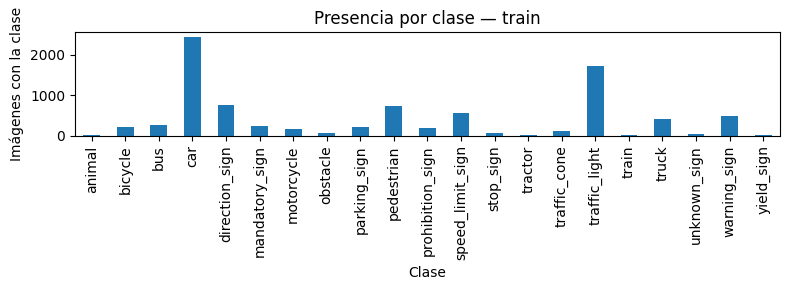

In [23]:
summarize_split(df_train, issues_train, "train")


=== [VALID] ===
Imágenes totales:         764
Con ≥1 clase presente:    688
Sin ninguna clase (neg.): 76
Presencia por clase:
  - animal               0
  - bicycle              37
  - bus                  60
  - car                  565
  - direction_sign       211
  - mandatory_sign       48
  - motorcycle           40
  - obstacle             4
  - parking_sign         85
  - pedestrian           134
  - prohibition_sign     56
  - speed_limit_sign     56
  - stop_sign            37
  - tractor              2
  - traffic_cone         34
  - traffic_light        377
  - train                2
  - truck                85
  - unknown_sign         23
  - warning_sign         106
  - yield_sign           4
Incidencias:
  - images_count: 764
  - missing_label_files: 0
  - invalid_class_ids: 0
  - empty_label_files: 76


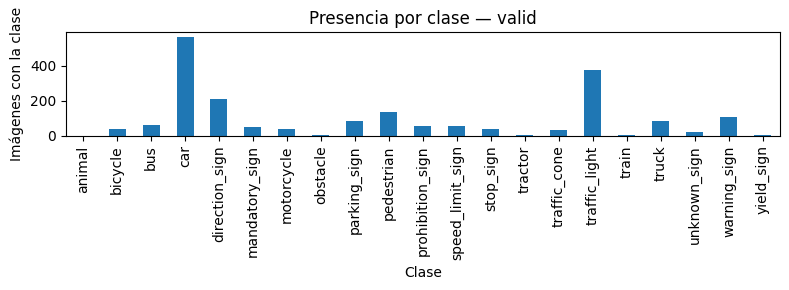

In [24]:
summarize_split(df_valid, issues_valid, "valid")


=== [TEST] ===
Imágenes totales:         1000
Con ≥1 clase presente:    994
Sin ninguna clase (neg.): 6
Presencia por clase:
  - animal               3
  - bicycle              42
  - bus                  103
  - car                  966
  - direction_sign       470
  - mandatory_sign       136
  - motorcycle           31
  - obstacle             40
  - parking_sign         133
  - pedestrian           249
  - prohibition_sign     96
  - speed_limit_sign     58
  - stop_sign            34
  - tractor              4
  - traffic_cone         54
  - traffic_light        426
  - train                3
  - truck                211
  - unknown_sign         53
  - warning_sign         239
  - yield_sign           9
Incidencias:
  - images_count: 1000
  - missing_label_files: 0
  - invalid_class_ids: 0
  - empty_label_files: 6


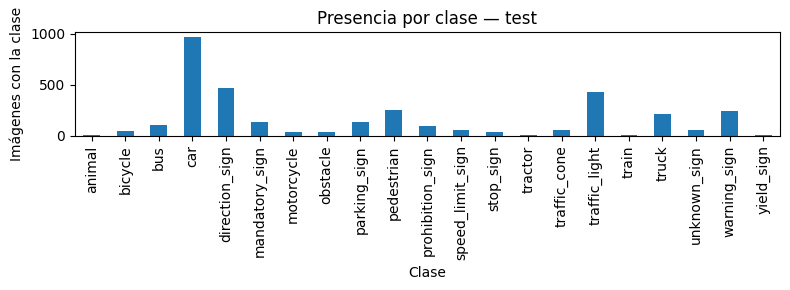

In [25]:
summarize_split(df_test,  issues_test,  "test")

In [26]:
# 2.4 Generadores Keras (multietiqueta, rescale=1./255)
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)
datagen_test  = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_dataframe(
    dataframe=df_train,
    directory=str(DR_TRAIN_IMAGES),
    x_col="filename",
    y_col=class_cols,
    class_mode="raw",            # Multietiqueta
    target_size=(ROWS, COLS),
    color_mode="rgb",
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

valid_gen = datagen_valid.flow_from_dataframe(
    dataframe=df_valid,
    directory=str(DR_VALID_IMAGES),
    x_col="filename",
    y_col=class_cols,
    class_mode="raw",
    target_size=(ROWS, COLS),
    color_mode="rgb",
    batch_size=BATCH,
    shuffle=False
)

test_gen = datagen_test.flow_from_dataframe(
    dataframe=df_test,
    directory=str(DR_TEST_IMAGES),
    x_col="filename",
    y_col=class_cols,
    class_mode="raw",
    target_size=(ROWS, COLS),
    color_mode="rgb",
    batch_size=BATCH,
    shuffle=False
)

Found 3350 validated image filenames.
Found 764 validated image filenames.
Found 1000 validated image filenames.


In [28]:
# Fit and Evaluate

def compute_steps(n_samples, batch_size, max_samples=None):
    total = min(n_samples, max_samples) if (max_samples and max_samples > 0) else n_samples
    return int(np.ceil(total / float(batch_size))) if total > 0 else 0

STEPS_PER_EPOCH = compute_steps(train_gen.n, BATCH, TRAIN_SAMPLES)
VAL_STEPS       = compute_steps(valid_gen.n, BATCH, None)         # Usar todo valid
TEST_STEPS      = compute_steps(test_gen.n,  BATCH, TEST_SAMPLES)

print("\n[INFO] Steps:")
print(f"  STEPS_PER_EPOCH = {STEPS_PER_EPOCH}")
print(f"  VAL_STEPS       = {VAL_STEPS}")
print(f"  TEST_STEPS      = {TEST_STEPS}")

if STEPS_PER_EPOCH == 0:
    print("[WARN] No hay muestras en train. Revisa rutas/extensiones/clases.")


[INFO] Steps:
  STEPS_PER_EPOCH = 94
  VAL_STEPS       = 24
  TEST_STEPS      = 32


## **Modelo Keras multietiqueta**

Entrenar una **CNN sencilla** en TensorFlow/Keras que, dada una imagen completa, prediga **qué clases aparecen** en ella (pueden ser varias a la vez).

**Arquitectura**

* **Entrada:** `input_shape = SHAPE` (por ej. 224×224×3).
* **Bloques convolucionales:** 2–3 repeticiones de `Conv2D(32, 3×3, relu)` seguidas de `MaxPooling2D(2×2)` para reducir resolución y extraer patrones.
* **Cabeza densa:** `Flatten()` → `Dense(512, relu)` para combinar características.
* **Capa de salida:** `Dense(N_CLASS, activation='sigmoid')`.

  * Cambiamos **softmax → sigmoid** porque **pueden activarse varias clases** simultáneamente (no son mutuamente excluyentes).

> Nota: Seguimos un diseño **ligero** para iterar rápido.

**Compilación (pérdida y métricas)**

* **Optimizador:** `Adam(learning_rate=1e-4)`
* **Pérdida:** `binary_crossentropy` (una BCE por clase, suma/promedio).
* **Métricas:**
  * `binary_accuracy` (rápida, pero puede ser optimista si hay muchas ausencias).
  * Recomendado añadir métricas por probabilidad: `AUC` multi-etiqueta, y/o precisión/recobrado micro/macro para el informe.
* **Reescalado:** ya lo aplican los generadores con `rescale=1./255`

**Callbacks (entrenamiento más estable)**

* **ModelCheckpoint:** guardar pesos por época o el “mejor” según `val_loss` (carpeta `runs_tf/detect_cnn_multilabel/`).
* **EarlyStopping (opcional):** parar si `val_loss` no mejora tras X épocas (útil con `EPOCHS` grandes).
* **TensorBoard (opcional):** para visualizar curvas de entrenamiento.


**Limitaciones y siguiente paso**

* Este modelo **no produce cajas**; solo presencia/ausencia de clases.
* Sirve como **baseline didáctico** y para detectar si el dataset/clases están bien formados.
* **Próximo paso** en el mismo notebook: sección de **detección real con KerasCV** (mAP y cajas), que sí cumple la necesidad del HUD.

In [39]:
import os, json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [30]:
# Comprobar que existen los generadores de la Sección 2
assert 'train_gen' in globals() and 'valid_gen' in globals() and 'test_gen' in globals(), \
    "Faltan los generadores (train_gen/valid_gen/test_gen) de la Sección 2."
assert 'STEPS_PER_EPOCH' in globals() and 'VAL_STEPS' in globals() and 'TEST_STEPS' in globals(), \
    "Faltan STEPS_PER_EPOCH / VAL_STEPS / TEST_STEPS (calculados en la Sección 2)."

In [34]:
# Definición y compilación del modelo
model = Sequential(name="cnn_multilabel_baseline")
model.add(Input(shape=SHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(N_CLASS, activation='sigmoid'))  # Multietiqueta

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        tf.keras.metrics.AUC(name='auc', multi_label=True)
    ]
)

print(model.summary())

Model: "cnn_multilabel_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │        10,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,218,773 (84.76 MB)

 Trainable params: 22,218,773 (84.76 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Callbacks y carpetas de salida

RUNS_DIR = REPO_ROOT / "runs_tf" / "detect_cnn_multilabel"
RUNS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_BEST = RUNS_DIR / "best.keras"

cbs = [
    # Guardar el mejor modelo según la métrica de validación
    ModelCheckpoint(
        filepath=str(CKPT_BEST),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Si el val_loss no mejora, detener el entrenamiento en 5 épocas y restaura los mejores pesos
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Visualización de curvas y métricas en TensorBoard
    TensorBoard(
        log_dir=str(RUNS_DIR / "tb"),
        write_graph=False
    )
]

In [ ]:
# Entrenamiento
if STEPS_PER_EPOCH == 0 or VAL_STEPS == 0:
    raise RuntimeError("STEPS_PER_EPOCH o VAL_STEPS es 0. Revisa datos y parámetros.")

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_gen,
    validation_steps=VAL_STEPS,
    callbacks=cbs,
    verbose=1
)

In [ ]:
# Guardar historial
with open(RUNS_DIR / "history.json", "w", encoding="utf-8") as f:
    json.dump(history.history, f, indent=2) # Persistimos las curvas para consultarlas sin necesidad de reentrenar

In [ ]:
# Curvas de entrenamiento (pérdida y accuracy binaria)
try:
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Curvas de pérdida")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

    if "binary_accuracy" in history.history:
        plt.figure(figsize=(6,4))
        plt.plot(history.history["binary_accuracy"], label="train_bin_acc")
        plt.plot(history.history["val_binary_accuracy"], label="val_bin_acc")
        plt.title("Curvas de binary_accuracy")
        plt.xlabel("Época"); plt.ylabel("Binary Acc"); plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("[WARN] No se pudieron graficar curvas:", e)

In [ ]:
# Evaluación en TEST
# Cargar el mejor modelo guardado (por si EarlyStopping no coincide con el checkpoint)
best_model = tf.keras.models.load_model(CKPT_BEST)
test_metrics = best_model.evaluate(
    test_gen,
    steps=TEST_STEPS if TEST_STEPS > 0 else None,
    verbose=1
)
print("\n[TEST] Métricas (orden según model.metrics_names):")
print(list(zip(best_model.metrics_names, test_metrics)))

In [ ]:
# Predicción y métricas con umbral

# Obtener predicciones probabilísticas
pred_probs = best_model.predict(
    test_gen,
    steps=TEST_STEPS if TEST_STEPS > 0 else None,
    verbose=1
)

# Etiquetas reales
y_true = test_gen.labels
# Alinear tamaño por si usamos TEST_STEPS que no cubre todo el set
n_preds = pred_probs.shape[0]
y_true = y_true[:n_preds]

# Umbral 0.5 (puedes ajustar por clase más adelante)
y_pred = (pred_probs >= 0.5).astype(int)

In [ ]:
# Métricas de clasificación multi-etiqueta (micro/macro)
results_report = {"note": "threshold=0.5", "classes": list(class_cols)}
try:
    # Micro y macro
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    # Por clase
    p_pc, r_pc, f1_pc, support_pc = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    results_report.update({
        "micro": {"precision": float(p_micro), "recall": float(r_micro), "f1": float(f1_micro)},
        "macro": {"precision": float(p_macro), "recall": float(r_macro), "f1": float(f1_macro)},
        "per_class": [
            {
                "class": class_cols[i],
                "precision": float(p_pc[i]),
                "recall": float(r_pc[i]),
                "f1": float(f1_pc[i]),
                "support": int(support_pc[i])
            } for i in range(len(class_cols))
        ]
    })

    print("\n[TEST] Micro/macro F1 con threshold=0.5")
    print(json.dumps(results_report["micro"], indent=2))
    print(json.dumps(results_report["macro"], indent=2))

except Exception as e:
    print("[WARN] sklearn no disponible o error calculando métricas detalladas:", e)

In [ ]:
# Guardar reporte y configuración mínima para reproducibilidad local
artifact = {
    "experiment_name": EXPERIMENT_NAME,
    "dataset_version": DATASET_VERSION,
    "input_shape": SHAPE,
    "rescale": "1./255",
    "classes": list(class_cols),
    "threshold": 0.5,
    "test_metrics_keras": dict(zip(best_model.metrics_names, [float(x) for x in test_metrics])),
    "test_metrics_report": results_report
}
with open(RUNS_DIR / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(artifact, f, indent=2, ensure_ascii=False)

print(f"\n[OK] Guardados artefactos en: {RUNS_DIR}")
print(f" - Mejor modelo: {CKPT_BEST.name}")
print(" - history.json, manifest.json")